<a href="https://colab.research.google.com/github/jorgelinaasmus/Entrega-Final-Coder/blob/main/ASMUS_TrabajoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

El interés por el avistamiento de aves ha crecido mucho en los últimos años, especialmente por especies fascinantes como los flamencos. 🦩✨ Este auge representa una gran oportunidad laboral en el turismo, ya que los guías ofrecen experiencias únicas que conectan a los viajeros con la naturaleza. 🌍👀 Al promover el ecoturismo, no solo se generan ingresos para las comunidades, sino que también se fomenta la conservación del medio ambiente.:


**Objetivo**📱🐦🦜🦩🚀



*   Desarrollar una aplicación que permita predecir la especie de flamenco avistada utilizando datos simples proporcionados por el usuario.

Para poder alcanzar ese objetivo, utilizaré una base de datos de registros proporcionada por Gbif. Entrenaré un modelo de ML con información sobre la provincia donde se realizó el avistamiento, el mes, la cantidad de individuos vistos y el color del tobillo. Esas variables explictivas servirán para predecir si el ave que el usuario tiene en frente será *Phoenicoparrus andinus*, *Phoenicopterus chilensis* o *Phoenicoparrus jamesi*.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix



In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#%cd '/content/gdrive/MyDrive'
df= pd.read_excel('/content/gdrive/MyDrive/CODERJA/basedatosfl.xlsx')
df.head()

,scientificName,gbifID,institutionCode,basisOfRecord,catalogNumber,recordedBy,individualCount,lifeStage,associatedTaxa,eventDate,...,continent,countryCode,ankle,stateProvince,verbatimLocality,verbatimElevation,decimalLatitude,decimalLongitude,genus,iucnRedListCategory
0,Phoenicopterus chilensis,4919700337,iNaturalist,HUMAN_OBSERVATION,231724261,JosÃ© Luis Ianiro,NaN,NaN,NaN,2023-12-09T20:30,...,SOUTH_AMERICA,AR,red,Buenos Aires,Mar Chiquita,NaN,-37.664367,-57.564824,Phoenicopterus,NT
1,Phoenicopterus chilensis,4909243786,iNaturalist,HUMAN_OBSERVATION,228453101,Cory,NaN,NaN,NaN,2019-02-23T15:50:06,...,SOUTH_AMERICA,AR,red,Santa Cruz,General Arenales,NaN,-50.216073,-72.382326,Phoenicopterus,NT
2,Phoenicopterus chilensis,4908589766,iNaturalist,HUMAN_OBSERVATION,228032005,Aki Garate,NaN,NaN,NaN,2023-09-15T11:48,...,SOUTH_AMERICA,AR,red,Rio Negro,Bariloche,NaN,-41.116011,-71.337985,Phoenicopterus,NT
3,Phoenicopterus chilensis,4903768259,iNaturalist,HUMAN_OBSERVATION,226209661,Walter Bustamante,NaN,NaN,NaN,2023-07-21T15:40,...,SOUTH_AMERICA,AR,red,Santiago del Estero,Lincoln,NaN,-27.727759,-64.330467,Phoenicopterus,NT
4,Phoenicopterus chilensis,4902118708,iNaturalist,HUMAN_OBSERVATION,224307859,Matias Cabezas,NaN,NaN,NaN,2019-11-18T18:51,...,SOUTH_AMERICA,AR,red,Santa Cruz,Lago Buenos Aires,NaN,-47.009806,-71.139891,Phoenicopterus,NT


In [ ]:
df.describe()

,gbifID,individualCount,startDayOfYear,year,month,day,verbatimElevation,decimalLatitude,decimalLongitude
count,2.957500e+04,25969.000000,29573.000000,29575.000000,29575.000000,29575.000000,8.000000,29575.000000,29575.000000
mean,3.959445e+09,182.983788,191.489433,2021.480473,6.814776,15.219577,1970.000000,-37.545115,-65.835084
std,7.075106e+08,1221.675475,112.422391,1.397600,3.661967,8.703404,1912.554089,9.373641,4.181991
min,1.993763e+09,1.000000,1.000000,2019.000000,1.000000,1.000000,70.000000,-54.817960,-73.032135
25%,3.335155e+09,4.000000,83.000000,2020.000000,3.000000,8.000000,767.500000,-46.883057,-69.225460
50%,4.221731e+09,13.000000,208.000000,2022.000000,7.000000,15.000000,1000.000000,-36.575104,-65.857836
75%,4.647959e+09,50.000000,292.000000,2023.000000,10.000000,23.000000,3823.250000,-30.930727,-62.771890
max,4.919700e+09,56703.000000,366.000000,2023.000000,12.000000,31.000000,4525.000000,-21.931187,-56.643772


Las variables que me proporciona la base de datos descargada de Gbif son:

*   scientificName: El nombre científico de la especie, siguiendo la nomenclatura binomial (género y especie).
*   gbifID: Un identificador único asignado por el Global Biodiversity Information Facility (GBIF) para rastrear registros.
*   institutionCode: Código que identifica la institución o colección que alberga el espécimen o el registro.
*   basisOfRecord: Indica la fuente del registro, como una observación, espécimen, fotografía, etc.
*   catalogNumber: Un número único asignado a cada espécimen en una colección para su identificación.
*   recordedBy: El nombre de la persona o entidad que registró la observación o recolectó el espécimen.
*   individualCount: Número de individuos de la especie observados o recolectados en un evento.
*   lifeStage: La etapa de vida del individuo (por ejemplo, huevo, juvenil, adulto).
*   associatedTaxa: Otras especies que están asociadas con el registro, como plantas o animales que cohabitan con la especie observada.
*   eventDate: La fecha en la que ocurrió la observación o recolección.
*   eventTime: La hora en la que se registró el evento.
*   startDayOfYear: Día del año en que ocurrió el evento (1-365 o 1-366 en años bisiestos).
*   year: El año en el que se realizó la observación o recolección.
*   month: El mes en que ocurrió el evento (1-12).
*   day: El día del mes en que ocurrió el evento.
*   continent: El continente donde se realizó la observación (por ejemplo, América del Sur).
*   countryCode: Código del país según estándares internacionales (por ejemplo, AR para Argentina).
*   ankle: Puede referirse al color o características del tobillo del ave, que es relevante para la identificación de ciertas especies.
*   stateProvince: La provincia o estado dentro del país donde se realizó la observación.
*   verbatimLocality: localidad se realizó la observación.
*   verbatimElevation: Elevación en metros sobre el nivel del mar donde se hizo la observación.
*   decimalLatitude: Latitud decimal del lugar donde se realizó la observación.
*   decimalLongitude: Longitud decimal del lugar de la observación.
*   genus: El género al que pertenece la especie, parte de la nomenclatura binomial.
*   iucnRedListCategory: Categoría del listado de la UICN que indica el estado de conservación de la especie (por ejemplo, vulnerable, en peligro, etc.).


🌍🤓 Para conocer más a estas tres especies de flamencos hice el siguiente mapa de distribución de todos los registros. Vemos que las tres especies son simpátricas, es decir, habitan en la misma área geográfica y pueden coexistir. Esto dificulta su identificación por que podemos llegar a un lugar por ejemplo Miramar de Ansenuza (Córdoba) y encontrarnos a las tres especies. ¿Cómo sé cual es cuál?.

--2024-10-17 11:59:14--  https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip
Resolving naturalearth.s3.amazonaws.com (naturalearth.s3.amazonaws.com)... 52.92.147.193, 52.218.236.219, 52.92.248.1, ...
Connecting to naturalearth.s3.amazonaws.com (naturalearth.s3.amazonaws.com)|52.92.147.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 214976 (210K) [application/zip]
Saving to: ‘ne_110m_admin_0_countries.zip.2’

ne_110m_admin_0_cou 100%[===================>] 209.94K  --.-KB/s    in 0.06s   

2024-10-17 11:59:15 (3.50 MB/s) - ‘ne_110m_admin_0_countries.zip.2’ saved [214976/214976]

Archive:  ne_110m_admin_0_countries.zip
replace ne_110m_admin_0_countries.README.html? [y]es, [n]o, [A]ll, [N]one, [r]ename: Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
       ...
       'FCLASS_TR', 'FCLASS_ID', 'FCLASS_PL', 'FCLASS_GR', 'FCLASS_IT',
       'FCLASS_NL', 'FCLA

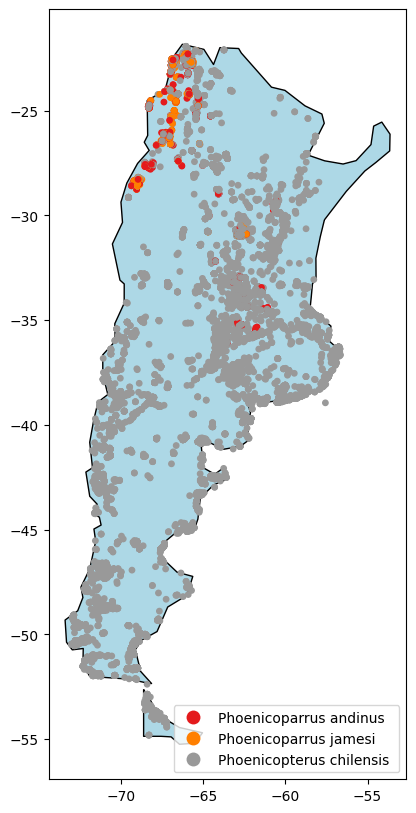

In [ ]:

!wget https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip
!unzip ne_110m_admin_0_countries.zip

# Load the world map from the downloaded shapefile
world = gpd.read_file("ne_110m_admin_0_countries.shp")

# Check the available columns in the 'world' GeoDataFrame
print(world.columns)

# Assuming the column containing country names is 'ADMIN', replace 'name' with 'ADMIN'
argentina = world[world['ADMIN'] == 'Argentina']

# Create geometry of points from the coordinates
geometry = [Point(xy) for xy in zip(df['decimalLongitude'], df['decimalLatitude'])]

# Create GeoDataFrame with the WGS84 reference system (EPSG:4326)
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Plot the map of Argentina with a larger size
ax = argentina.plot(figsize=(14, 10), color='lightblue', edgecolor='black')

# Plot the species points, assigning different colors and with smaller points
gdf.plot(ax=ax, marker='o', column='scientificName', legend=True, cmap='Set1', markersize=15)

# Show the plot
plt.show()


Antes de aplicar el análisis debemos corregir algunos valores o nombres de variables que tienen errores de tipeo.

In [ ]:
#reemplazar data "CÃ³rdoba" por "Cordoba"
df["stateProvince"] = df['stateProvince'].replace('CÃ³rdoba', 'Cordoba')
#visualizar
resumen_provincias = df['stateProvince'].value_counts()
print(resumen_provincias)

stateProvince
Santa Cruz             7166
Buenos Aires           3907
Cordoba                3643
Jujuy                  3252
Chubut                 1910
La Pampa               1803
Santa Fe               1439
Neuquen                1417
Rio Negro              1131
Salta                   940
Mendoza                 866
Tierra del Fuego        524
Santiago del Estero     510
Catamarca               509
La Rioja                156
San Luis                 95
Entre Rios               88
Chaco                    60
Corrientes               59
Tucuman                  50
San Juan                 25
Formosa                  24
Santa Cruz                1
Name: count, dtype: int64


In [ ]:
#reemplazar data "Santa Cruz " por "Santa Cruz"
df["stateProvince"] = df['stateProvince'].replace("Santa Cruz ", 'Santa Cruz')
#visualizar
resumen_provincias = df['stateProvince'].value_counts()
print(resumen_provincias)

stateProvince
Santa Cruz             7167
Buenos Aires           3907
Cordoba                3643
Jujuy                  3252
Chubut                 1910
La Pampa               1803
Santa Fe               1439
Neuquen                1417
Rio Negro              1131
Salta                   940
Mendoza                 866
Tierra del Fuego        524
Santiago del Estero     510
Catamarca               509
La Rioja                156
San Luis                 95
Entre Rios               88
Chaco                    60
Corrientes               59
Tucuman                  50
San Juan                 25
Formosa                  24
Name: count, dtype: int64


La pregunta que siempre hay que hacerse...¿Existen datos nulos?

In [ ]:
print(df.isnull().sum())

scientificName             0
gbifID                     0
institutionCode           36
basisOfRecord              0
catalogNumber              5
recordedBy                 2
individualCount         3606
lifeStage              29439
associatedTaxa         29564
eventDate                  0
eventTime              27488
startDayOfYear             2
year                       0
month                      0
day                        0
continent                  0
countryCode                0
ankle                      0
stateProvince              0
verbatimLocality           0
verbatimElevation      29567
decimalLatitude            0
decimalLongitude           0
genus                      0
iucnRedListCategory        0
dtype: int64


Hay muchos datos faltantes. También nos preguntamos ¿Los datos se encuentran balanceados?

In [ ]:
df['scientificName'].value_counts()

,count
scientificName,
Phoenicopterus chilensis,25928
Phoenicoparrus jamesi,1872
Phoenicoparrus andinus,1775


Vemos que NO! Y como los datos se encuentran muy desbalanceados, siendo *P. chilensis* la especie que se lleva la mayoría de registros, dejaré los registros de *P.chilensis* sólo para el año 2023. Mientras que las otras dos especies utilizaré registros toados entre los años 2019 a 2023.
También filtraré aquellos registros donde se haya especificado el n° de individuos avistados.

In [ ]:
# Me aseguro de que los espacios en blanco y mayúsculas no interfieran
df['scientificName'] = df['scientificName'].str.strip()

# Eliminar las filas donde scientificName es 'Phoenicopterus chilensis' y el año esté entre 2019 y 2022
df1 = df[~((df['scientificName'] == 'Phoenicopterus chilensis') & (df['year'].between(2019, 2022)))]


In [ ]:
df1['scientificName'].value_counts()

,count
scientificName,
Phoenicopterus chilensis,8383
Phoenicoparrus jamesi,1872
Phoenicoparrus andinus,1775


In [ ]:
df1 = df1.dropna(subset=['individualCount'])


In [ ]:
print(df1.isnull().sum())
df1['scientificName'].value_counts()

scientificName             0
gbifID                     0
institutionCode           16
basisOfRecord              0
catalogNumber              1
recordedBy                 0
individualCount            0
lifeStage              10378
associatedTaxa         10394
eventDate                  0
eventTime              10375
startDayOfYear             0
year                       0
month                      0
day                        0
continent                  0
countryCode                0
ankle                      0
stateProvince              0
verbatimLocality           0
verbatimElevation      10394
decimalLatitude            0
decimalLongitude           0
genus                      0
iucnRedListCategory        0
dtype: int64


,count
scientificName,
Phoenicopterus chilensis,7220
Phoenicoparrus jamesi,1639
Phoenicoparrus andinus,1535


Los datos están un poco más equitativos aunque *P.chilensis* sigue siendo la especie más avistada. Esto tiene sentido porque es la especie con la distribución más amplia y tiene las poblaciones más grandes.
Para entrenar el modelo, me voy a quedar con las variables:scientificName, individualcounts, month, province y ankle.

In [ ]:
datos = df1[['scientificName', 'individualCount', 'month', 'stateProvince', 'ankle']].copy()

print(datos)

                 scientificName  individualCount  month stateProvince   ankle
152      Phoenicoparrus andinus              9.0      9  Buenos Aires  yellow
154       Phoenicoparrus jamesi              1.0     12         Jujuy     red
155       Phoenicoparrus jamesi              1.0     12         Jujuy     red
156    Phoenicopterus chilensis              8.0      3        Chubut     red
157    Phoenicopterus chilensis              1.0      3  Buenos Aires     red
...                         ...              ...    ...           ...     ...
29399     Phoenicoparrus jamesi             20.0      1      La Rioja     red
29414     Phoenicoparrus jamesi              4.0      2         Salta     red
29415     Phoenicoparrus jamesi             19.0      1      La Rioja     red
29430    Phoenicoparrus andinus            100.0      1         Jujuy  yellow
29438     Phoenicoparrus jamesi             19.0      1      La Rioja     red

[10394 rows x 5 columns]


Estas variables a utilizar deben ser transformadas para que puedan modelarse.

1.   Transformar la columna scientificName en la variable target (y), donde *P.chilensis* sea=0, *P.andinus*=1 y *P.jamesi*=2.
2.   Transformar ankle en 0 y 1.
3.   Codificar a las provincias (22) en variables dummy (one Hot Encoder).
4.    Codificar los meses del año (12) en variables dummy (one Hot Encoder).
5.   Normalizar la unica varible cuantitativa.




In [ ]:
#1:
#Mapeo de los nombres científicos a valores numéricos
mapping = {
    'Phoenicopterus chilensis': 0,
    'Phoenicoparrus andinus': 1,
    'Phoenicoparrus jamesi': 2
}

# Transformar la columna 'scientificName' a 'target'
datos['target'] = datos['scientificName'].replace(mapping)

# Eliminar la columna original 'scientificName' si ya no la necesitas
datos = datos.drop(columns=['scientificName'])

# Mostrar el DataFrame resultante
print(datos)

       individualCount  month stateProvince   ankle  target
152                9.0      9  Buenos Aires  yellow       1
154                1.0     12         Jujuy     red       2
155                1.0     12         Jujuy     red       2
156                8.0      3        Chubut     red       0
157                1.0      3  Buenos Aires     red       0
...                ...    ...           ...     ...     ...
29399             20.0      1      La Rioja     red       2
29414              4.0      2         Salta     red       2
29415             19.0      1      La Rioja     red       2
29430            100.0      1         Jujuy  yellow       1
29438             19.0      1      La Rioja     red       2

[10394 rows x 5 columns]


<ipython-input-110-523088c43336>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  datos['target'] = datos['scientificName'].replace(mapping)


In [ ]:
#2:
#Mapeo de los nombres científicos a valores numéricos
mapping = {
    'red': 0,
    'yellow': 1,
}

datos['ankle'] = datos['ankle'].replace(mapping)

# Mostrar el DataFrame resultante
print(datos)

       individualCount  month stateProvince  ankle  target
152                9.0      9  Buenos Aires      1       1
154                1.0     12         Jujuy      0       2
155                1.0     12         Jujuy      0       2
156                8.0      3        Chubut      0       0
157                1.0      3  Buenos Aires      0       0
...                ...    ...           ...    ...     ...
29399             20.0      1      La Rioja      0       2
29414              4.0      2         Salta      0       2
29415             19.0      1      La Rioja      0       2
29430            100.0      1         Jujuy      1       1
29438             19.0      1      La Rioja      0       2

[10394 rows x 5 columns]


<ipython-input-111-6c3edc45d714>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  datos['ankle'] = datos['ankle'].replace(mapping)


In [ ]:
#3:
prov = datos['stateProvince'].unique()
prov

array(['Buenos Aires', 'Jujuy', 'Chubut', 'Santa Cruz', 'Cordoba',
       'Catamarca', 'Santa Fe', 'Salta', 'La Pampa', 'Mendoza',
       'Entre Rios', 'Corrientes', 'Santiago del Estero', 'Neuquen',
       'Tierra del Fuego', 'Rio Negro', 'Chaco', 'Formosa', 'San Luis',
       'San Juan', 'La Rioja', 'Tucuman'], dtype=object)

In [ ]:
# Crear variables dummy para 'stateProvince'
dummies = pd.get_dummies(datos['stateProvince'], prefix='province')

# Concatenar las variables dummy al DataFrame original
datos = pd.concat([datos, dummies], axis=1)

# Eliminar la columna original 'stateProvince'
datos = datos.drop(columns=['stateProvince'])

# Mostrar el DataFrame resultante
print(datos)

       individualCount  month  ankle  target  province_Buenos Aires  \
152                9.0      9      1       1                   True   
154                1.0     12      0       2                  False   
155                1.0     12      0       2                  False   
156                8.0      3      0       0                  False   
157                1.0      3      0       0                   True   
...                ...    ...    ...     ...                    ...   
29399             20.0      1      0       2                  False   
29414              4.0      2      0       2                  False   
29415             19.0      1      0       2                  False   
29430            100.0      1      1       1                  False   
29438             19.0      1      0       2                  False   

       province_Catamarca  province_Chaco  province_Chubut  province_Cordoba  \
152                 False           False            False         

In [ ]:
#4:
# Crear variables dummy para 'month'
dummies_month = pd.get_dummies(datos['month'], prefix='month')

# Concatenar las variables dummy al DataFrame original
datos = pd.concat([datos, dummies_month], axis=1)

# Eliminar la columna original 'month'
datos = datos.drop(columns=['month'])

# Mostrar el DataFrame resultante
print(datos)

       individualCount  ankle  target  province_Buenos Aires  \
152                9.0      1       1                   True   
154                1.0      0       2                  False   
155                1.0      0       2                  False   
156                8.0      0       0                  False   
157                1.0      0       0                   True   
...                ...    ...     ...                    ...   
29399             20.0      0       2                  False   
29414              4.0      0       2                  False   
29415             19.0      0       2                  False   
29430            100.0      1       1                  False   
29438             19.0      0       2                  False   

       province_Catamarca  province_Chaco  province_Chubut  province_Cordoba  \
152                 False           False            False             False   
154                 False           False            False             

In [ ]:
#5:
# Create an instance of the StandardScaler class
scaler = StandardScaler()

datos['individualCount'] = scaler.fit_transform(datos[['individualCount']])

AHORA TENGO TODAS LAS VARIABLES TRANSFORMADAS: TENGO QUE DIVIDIR EN X/Y

In [ ]:
# Asignar 'target' a y y el resto a X
y = datos['target']
X = datos.drop(columns=['target'])

In [ ]:
#separar train/test:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



El modelo que voy a aplicar es supervisado y de CLASIFICACIÓN: VECINO MÁS CERCANO O KNN.

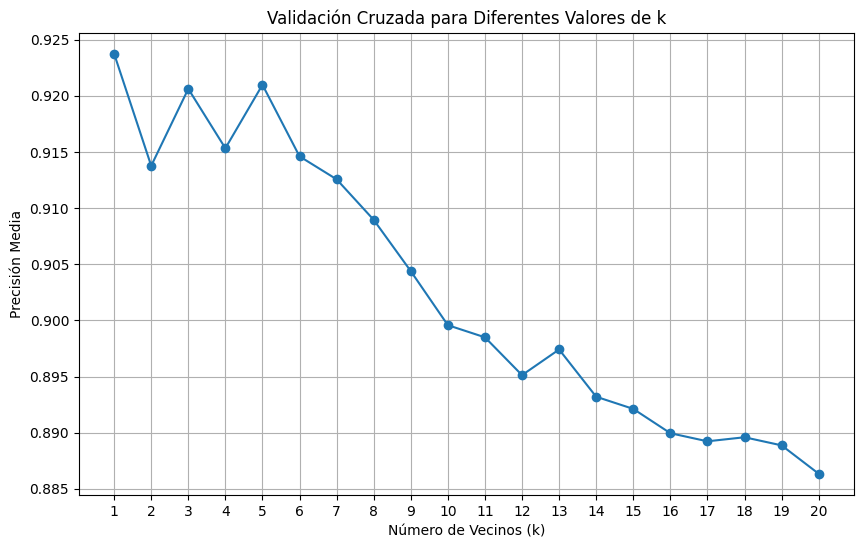

In [ ]:
k_values = range(1, 21)  # Probar valores de k de 1 a 20
scores = []

# Probar diferentes valores de k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Realizar validación cruzada
    score = cross_val_score(knn, X_train, y_train, cv=5)
    scores.append(score.mean())

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(k_values, scores, marker='o')
plt.title('Validación Cruzada para Diferentes Valores de k')
plt.xlabel('Número de Vecinos (k)')
plt.ylabel('Precisión Media')
plt.xticks(k_values)
plt.grid()
plt.show()

In [ ]:
# Crear el modelo KNN: ME QUEDO CON K=5
knn = KNeighborsClassifier(n_neighbors=5)  # Puedes ajustar el número de vecinos

# Entrenar el modelo
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
#Validar
y_pred = knn.predict(X_test)

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred) # Guardar el resultado de confusion_matrix en conf_matrix

print(conf_matrix)
print(classification_report(y_test, y_pred))

[[1364    0   92]
 [   4  294    4]
 [  76    0  245]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1456
           1       1.00      0.97      0.99       302
           2       0.72      0.76      0.74       321

    accuracy                           0.92      2079
   macro avg       0.89      0.89      0.89      2079
weighted avg       0.92      0.92      0.92      2079



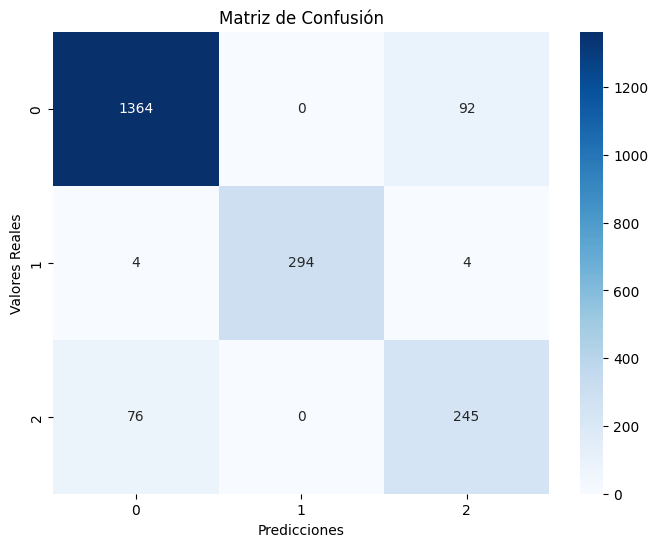

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()

Recordando...

Clase 0:  '*Phoenicoparrus chilensis*'
Clase 1:  '*Phoenicoparrus andinus*'
Clase 2:  '*Phoenicoparrus jamesi*'

**Conclusiones:**
Clase 0 tiene una alta tasa de verdaderos positivos, pero hay confusión con la clase 2 (92 predicciones incorrectas).
Clase 1 tiene muy pocos falsos positivos y falsos negativos, indicando que el modelo es bastante preciso para esta clase.
Clase 2 tiene también una buena cantidad de verdaderos positivos, pero tiene confusión con la clase 0 (76 predicciones incorrectas).

Probamos otro modelo: RANDOM FOREST:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, random_state=42)

In [ ]:
# Obtener predicciones
y_pred= clf.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_pred=y_pred, y_true= y_test))

              precision    recall  f1-score   support

           0       0.83      1.00      0.90      1456
           1       1.00      1.00      1.00       302
           2       0.87      0.04      0.08       321

    accuracy                           0.85      2079
   macro avg       0.90      0.68      0.66      2079
weighted avg       0.86      0.85      0.79      2079



Comparando la precisión ambos modelos son buenos. En Random Forest la clase 0 y 2 tienen una presicion de 83 y 87% respectivamente, mientras que para knn 94 y 72. Lo que implica que es mejor Random Forest para aunmentar la presición de la prediccion para la clase2.
Para el recall de random forest, la clase 2 tiene un valor de 0.04 indica que solo el 4% de los casos positivos reales fueron identificados correctamente por el modelo. Esto es bastante bajo y sugiere que el modelo tiene dificultades para detectar la clase positiva en cuestión.
El f1-score también es demasiado bajo.

El mejor modelo es KNN.
